In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
import datetime
import os

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kaleb\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [13]:
folder_path = r"C:\Users\Kaleb\OneDrive\Documents\AC\Week1\Data\raw_analyst_ratings.csv"
file_name = "raw_analyst_ratings.csv"
file_path = os.path.join(folder_path, file_name)


In [14]:
df = pd.read_csv(file_path)

In [15]:
print("Dataset Preview:")
display(df.head())

Dataset Preview:


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [16]:
# -----------------------------------------------
# 1. Basic Descriptive Statistics
# -----------------------------------------------

# a. Headline Length
df['headline_length'] = df['headline'].apply(len)

print(f"Headline Length Stats:\n{df['headline_length'].describe()}")

Headline Length Stats:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


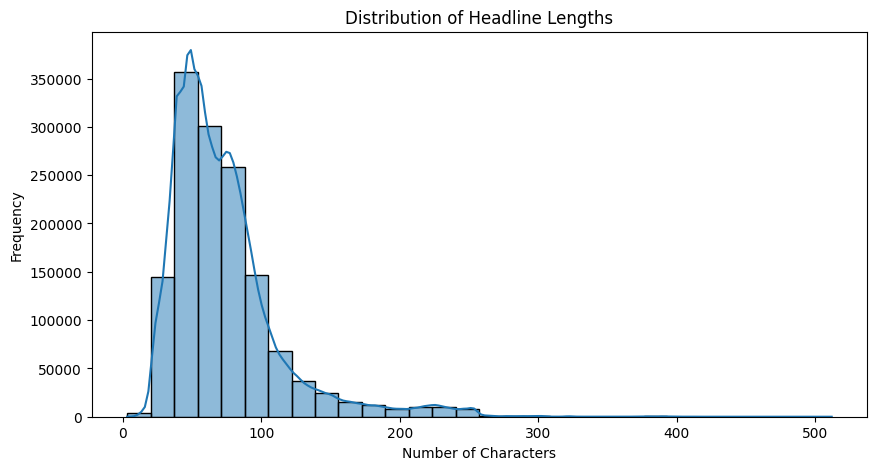

In [17]:
# Histogram of headline length
plt.figure(figsize=(10, 5))
sns.histplot(df['headline_length'], bins=30, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

In [18]:
publisher_counts = df['publisher'].value_counts()
print("\nTop 10 Publishers by Number of Articles:")
print(publisher_counts.head(10))


Top 10 Publishers by Number of Articles:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


C:\Users\Kaleb\AppData\Local\Temp\ipykernel_2112\4007593543.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=publisher_counts.head(10).index, x=publisher_counts.head(10).values, palette='viridis')


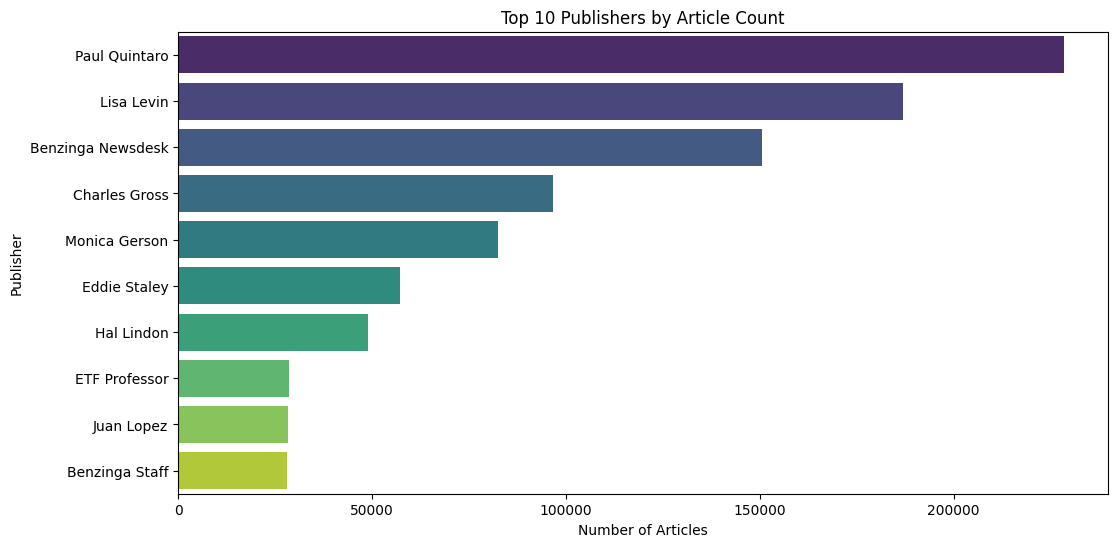

In [19]:
# Bar plot for top 10 publishers
plt.figure(figsize=(12, 6))
sns.barplot(y=publisher_counts.head(10).index, x=publisher_counts.head(10).values, palette='viridis')
plt.title('Top 10 Publishers by Article Count')
plt.xlabel('Number of Articles')
plt.ylabel('Publisher')
plt.show()

In [23]:
def parse_dates_mixed(date_str):
    try:
        # Try parsing timezone-aware date (ISO format)
        return pd.to_datetime(date_str, utc=True)
    except Exception:
        # Fallback: parse naive date with format DD/MM/YYYY, localize to UTC
        dt = pd.to_datetime(date_str, format="%d/%m/%Y", errors='coerce')
        if pd.isna(dt):
            return pd.NaT
        else:
            return dt.tz_localize('UTC')

In [24]:
# Apply the function to the 'date' column
df['date'] = df['date'].apply(parse_dates_mixed)

# Drop rows where 'date' could not be parsed (optional)
df = df.dropna(subset=['date'])

# Extract date (no time) for daily aggregation
df['date_only'] = df['date'].dt.date

# Number of articles per day
articles_per_day = df.groupby('date_only').size()

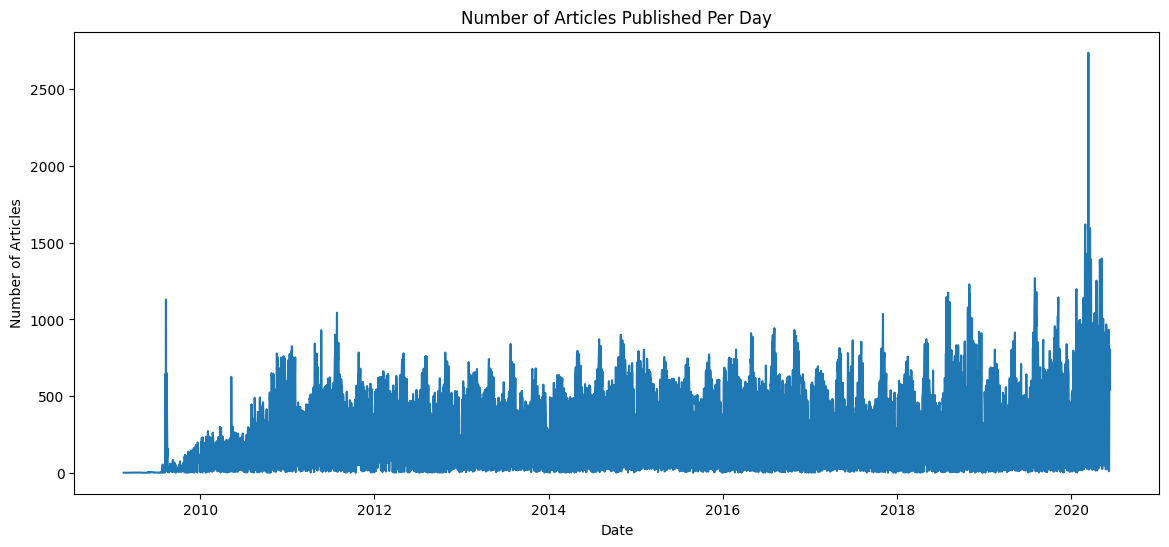

In [25]:
plt.figure(figsize=(14, 6))
articles_per_day.plot()
plt.title('Number of Articles Published Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

C:\Users\Kaleb\AppData\Local\Temp\ipykernel_2112\3572404334.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df, palette='coolwarm')


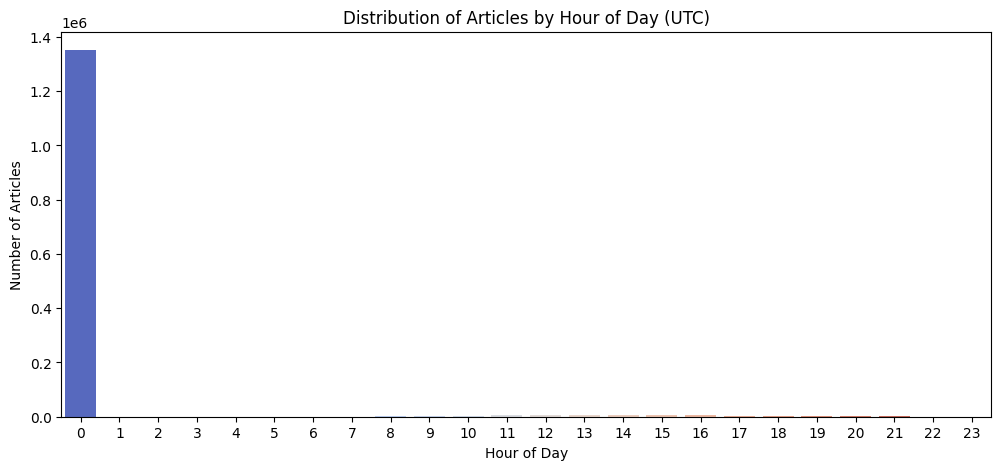

In [26]:
# Extract hour of publication to see distribution of publishing time
df['hour'] = df['date'].dt.hour

plt.figure(figsize=(12, 5))
sns.countplot(x='hour', data=df, palette='coolwarm')
plt.title('Distribution of Articles by Hour of Day (UTC)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles')
plt.show()

In [27]:
# -----------------------------------------------
# 3. Text Analysis: Common Keywords and Word Cloud
# -----------------------------------------------

# Prepare text data for word frequency (combine all headlines)
all_headlines = " ".join(df['headline'].astype(str)).lower()

In [28]:
# Tokenize words
words = all_headlines.split()

In [29]:
# Remove stopwords and punctuation
stop_words = set(stopwords.words('english'))
filtered_words = [word.strip('.,!?"\'') for word in words if word not in stop_words and word.isalpha()]

In [30]:
# Get the most common words
word_freq = Counter(filtered_words)
common_words = word_freq.most_common(30)

In [31]:
print("Top 30 Most Common Words in Headlines:")
for word, count in common_words:
    print(f"{word}: {count}")

Top 30 Most Common Words in Headlines:
stocks: 159102
vs: 138801
eps: 127403
shares: 112655
reports: 108429
market: 89225
earnings: 80855
top: 78354
sales: 77924
pt: 72733
announces: 66513
price: 63328
downgrades: 61862
trading: 60582
raises: 57735
target: 53530
maintains: 52958
est: 49316
new: 47662
buy: 43697
session: 43513
says: 42839
moving: 42203
upgrades: 42145
higher: 39041
sees: 37952
stock: 37218
initiates: 34981
lowers: 33854
us: 33725


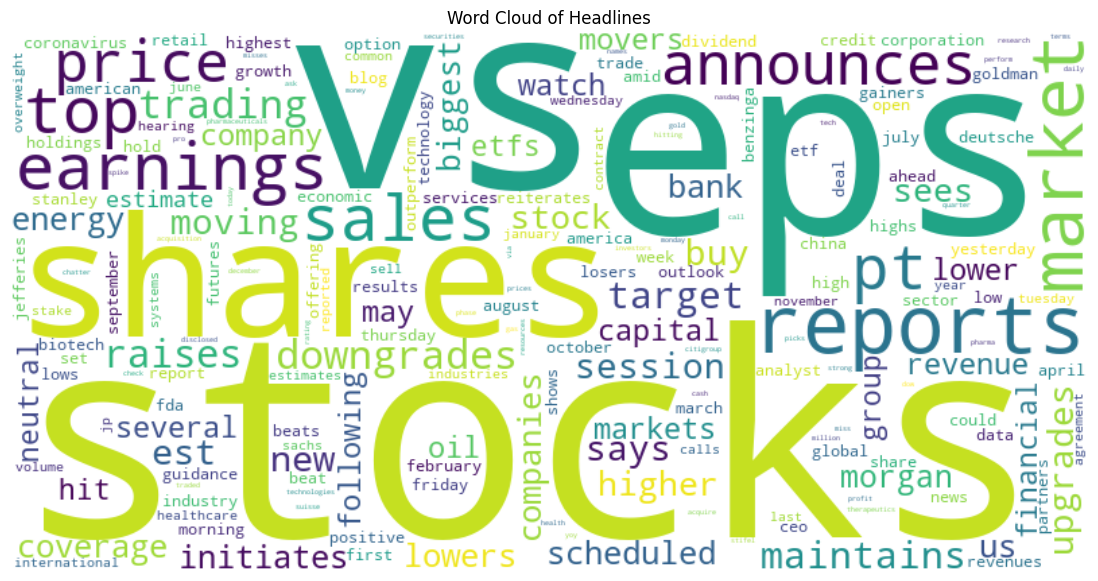

In [33]:
# Word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Headlines')
plt.show()

In [34]:
# -----------------------------------------------
# 4. Publisher Email Domain Analysis (if emails used)
# -----------------------------------------------

# Identify if publisher is an email (simple heuristic: contains '@')
df['is_email'] = df['publisher'].str.contains('@', na=False)

# Extract email domains
df['email_domain'] = df['publisher'].apply(lambda x: x.split('@')[1] if '@' in x else None)


Top 10 Email Domains Among Publishers:
email_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


C:\Users\Kaleb\AppData\Local\Temp\ipykernel_2112\3058736867.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=domain_counts.index, x=domain_counts.values, palette='magma')


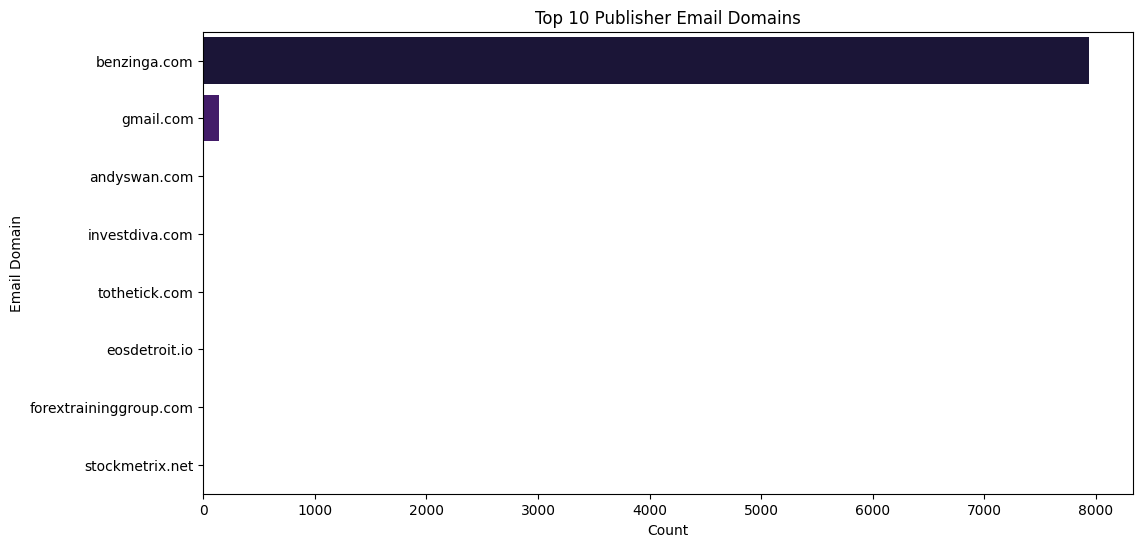

In [35]:
# Count email domains
domain_counts = df['email_domain'].value_counts().head(10)
print("\nTop 10 Email Domains Among Publishers:")
print(domain_counts)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(y=domain_counts.index, x=domain_counts.values, palette='magma')
plt.title('Top 10 Publisher Email Domains')
plt.xlabel('Count')
plt.ylabel('Email Domain')
plt.show()

In [36]:
# -----------------------------------------------
# 5. Summary and Save Results (Optional)
# -----------------------------------------------

# Save basic stats to CSV
publisher_counts.to_csv('publisher_article_counts.csv')
articles_per_day.to_csv('articles_per_day.csv')

print("\nEDA completed and outputs saved (publisher_article_counts.csv, articles_per_day.csv).")


EDA completed and outputs saved (publisher_article_counts.csv, articles_per_day.csv).
